# MOACIR - Mais Outro Algoritmo Classificador de Imagens da Roça

Olá, meu nome é MOACIR, sou a alma digitalizada de um antigo roceiro que manejava uma lavoura de mandioca. Bom se fosse, sou apenas mais um algoritmo classificador de imagens baseado em um desafio do Kaggle e fui desenvolvido enquanto meu programador ouvia Metal. \
    Link do desafio: https://www.kaggle.com/c/cassava-leaf-disease-classification/data \
    Desenvolvido por TODOHARDWARE: https://github.com/TODOHARDWARE \
    Apresentado no LAMIA, conheçam-o: https://lamia-edu.com

Antes de rodar este projeto, instale os requerimentos 


In [1]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


## Atenção
A versão do PyTorch usada neste projeto é a acelerada por GPU, neste caso ROCm que são para GPUs AMD \
Se você usa uma GPU Nvidia, desinstale o PyTorch instalado pelo requirements e instale a versão para CUDA

## Neste notebook vamos carregar o modelo e predizer a doença da planta de mandioca.

In [2]:
import os
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import sklearn.metrics
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
import multiprocessing as mp
%matplotlib inline

In [3]:
BASE_DIR = '/home/todohardware/BKPdataset/' 
map_labels = {0: 'Bacteriose (CBB)', 1: 'Doença das Estrias Marrons (CBSD)', 2: 'Mosqueado Verde (CGM)', 3: 'Mosaico (CMD)', 4: 'Saudavel'}
DIM = (224, 224) #mesma dimensão que nossa vitima costumava aprender
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = int(mp.cpu_count() * 0.75) # 75% dos nucleos da CPU, se for 8/16, usará 6/12
SEED = 1
DEVICE = 'cuda'
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [4]:
def predict_image(image_path, model, device):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image = np.array(image)
    image = image / 255.0
    image = (image - MEAN) / STD
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image, dtype=torch.float).unsqueeze(0).to(device)
    output = model(image)
    output = F.softmax(output, dim=1)
    return output.detach().cpu().numpy().flatten()

In [11]:
modelo = torch.load('/home/todohardware/BKPdataset/MOACIR.h5')
modelo.eval()
modelo.load_state_dict(torch.load('/home/todohardware/melhores_pesos'))
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [12]:
teste = pd.DataFrame(columns=['image_id', 'label', 'pred'])

In [13]:
for _, _, files in os.walk('/home/todohardware/Fotos Reais/'):
    for file in files:
        prediction = predict_image('/home/todohardware/Fotos Reais/' + file, modelo, DEVICE)
        max_index = np.argmax(prediction)
        if 'bacteriose' in file:
            label = 0
        if 'marrom' in file:
            label = 1
        if 'mosqueado' in file:
            label = 2
        if 'mosaico' in file:
            label = 3
        if 'saudavel' in file:
            label = 4
        
        teste = pd.concat([teste, pd.DataFrame({'image_id': [file], 'label': [label],
                                                'pred': [max_index]})]).reset_index(drop=True)

In [14]:
teste['label'] = teste['label'].astype(int)
teste['pred'] = teste['pred'].astype(int)

<Axes: >

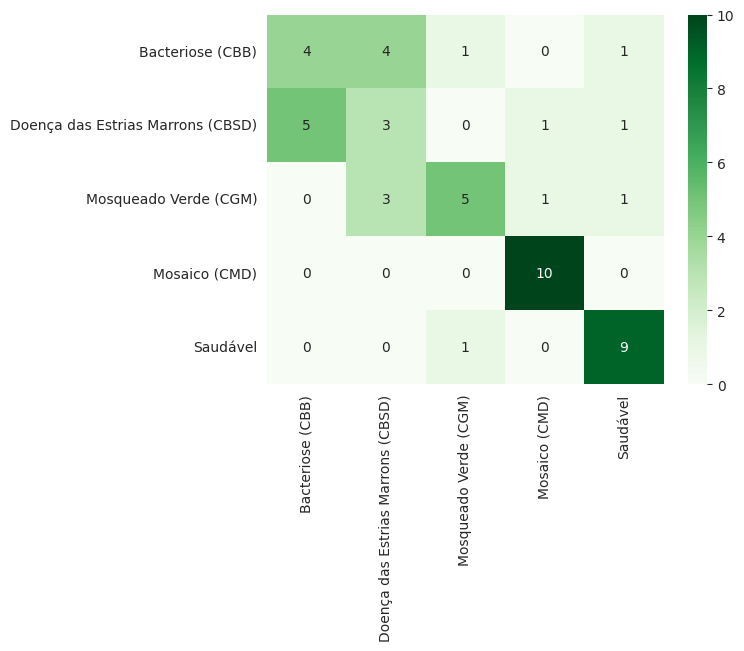

In [15]:
sns.heatmap(sklearn.metrics.confusion_matrix(teste['label'], teste['pred'], labels=[0, 1, 2, 3, 4]), annot=True, fmt='d', cmap='Greens', xticklabels=['Bacteriose (CBB)', 'Doença das Estrias Marrons (CBSD)', 'Mosqueado Verde (CGM)', 'Mosaico (CMD)', 'Saudável'], yticklabels=['Bacteriose (CBB)', 'Doença das Estrias Marrons (CBSD)', 'Mosqueado Verde (CGM)', 'Mosaico (CMD)', 'Saudável'])

In [16]:
print(sklearn.metrics.classification_report(teste['label'], teste['pred'], target_names=['Bacteriose (CBB)', 'Doença das Estrias Marrons (CBSD)', 'Mosqueado Verde (CGM)', 'Mosaico (CMD)', 'Saudável']))

                                   precision    recall  f1-score   support

                 Bacteriose (CBB)       0.44      0.40      0.42        10
Doença das Estrias Marrons (CBSD)       0.30      0.30      0.30        10
            Mosqueado Verde (CGM)       0.71      0.50      0.59        10
                    Mosaico (CMD)       0.83      1.00      0.91        10
                         Saudável       0.75      0.90      0.82        10

                         accuracy                           0.62        50
                        macro avg       0.61      0.62      0.61        50
                     weighted avg       0.61      0.62      0.61        50

